In [2]:
!pip install fastai

     |████████████████████████████████| 189 kB 1.5 MB/s 
     |████████████████████████████████| 10.5 MB 5.1 MB/s 
     |████████████████████████████████| 269 kB 8.0 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 295 kB 11.5 MB/s 
     |████████████████████████████████| 288 kB 11.1 MB/s 
     |████████████████████████████████| 1.1 MB 13.3 MB/s 
     |████████████████████████████████| 9.8 MB 8.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl size=44619 sha256=70db370d0ff048e41288b2c63fb857c1f35cec286642dd83e316548e34778b1d
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-266kq9io/wheels/13/90/db/290ab3a34f2ef0b5a0f89235dc2d40fea83e77de84ed2dc05c
Successfully built pyyaml
You should consider upgrading via the '/python/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from fastai.data.all import *
from fastai.text.all import *
from torch.utils.data import DataLoader as TorchDataLoader
from fastai.callback.all import *
from fastai.torch_core import *

from readers.DrQA import data, config, model
from gensim.models import KeyedVectors
import importlib
import numpy as np
import pandas as pd

from fastaifix.learner import summary

In [6]:
import fastai
print(fastai.__version__)

2.1.8


In [3]:
importlib.reload(data)
importlib.reload(config)
importlib.reload(model)

<module 'reader.model' from '/code/reader/model.py'>

In [7]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [8]:
seed_all(42)

In [9]:
args = config.Args()
args.weight_decay = 0.001
args.max_len = 150
args.hidden_size = 512
args.context_layers = 3
args.question_layers = 3
args.concat_rnn_layers = True
args.dropout_rnn = 0.2
args.dropout_emb = 0.2
args.layernorm_emb = True
args.dropout_rnn_output = True

In [8]:
print(args.dropout_rnn)
print(args.rnn_unit_type)
print(args.question_merge)

0.2
lstm
self_attn


In [9]:
DATASET_PATH = 'Dataset'
BATCH_SIZE = 32
# max_seq_length = 256
train_df = pd.read_csv('./Dataset/train_token.csv')
train_df = train_df.replace(np.nan, '', regex=True)
train_df = train_df[train_df['text'] != '']
train_df.head(5)

,Unnamed: 0,id,question,title,text,label
0,0,u7-1570446247_1,Quang_Hải giành được chức vô_địch U21 quốc_gia năm bao_nhiêu tuổi,Nguyễn Quang Hải (sinh 1997),"Năm 2013 , Nguyễn_Quang_Hải giành chức vô_địch U21 quốc_gia 2013 cùng với đội trẻ Hà_Nội T&T và tạo nên cú sốc khi trở_thành cầu_thủ 16 tuổi đầu_tiên giành được danh_hiệu vô_địch U21 quốc_gia .",True
1,1,u7-1570446247_2,Quang_Hải giành được chức vô_địch U21 quốc_gia năm bao_nhiêu tuổi,Nguyễn Quang Hải (sinh 1997),"Sau chức vô_địch U-21 quốc_gia 2013 , Nguyễn_Quang_Hải mới 16 tuổi lập_tức được HLV Phan_Thanh_Hùng điền vào danh_sách của đội bóng thủ_đô tham_dự V-League 2014 .",True
2,2,u7-1570446247_0,Quang_Hải giành được chức vô_địch U21 quốc_gia năm bao_nhiêu tuổi,Nguyễn Quang Hải (sinh 1997),Anh bắt_đầu gia_nhập lò đào_tạo trẻ Hà_Nội T&T khi mới 9 tuổi vào năm 2006 .,False
3,3,u7-1570446247_3,Quang_Hải giành được chức vô_địch U21 quốc_gia năm bao_nhiêu tuổi,Nguyễn Quang Hải (sinh 1997),"Năm 2011 , Nguyễn_Quang_Hải mới 14 tuổi được gọi lên đội_tuyển U-16 Việt_Nam , thi_đấu với những cầu_thủ lớn_tuổi hơn tại vòng_loại giải_vô_địch_bóng_đá U-16 châu Á.",False
4,4,u7-1570445661_0,Mỗi hiệp bóng_đá kéo_dài bao_lâu,Bóng đá,"Một trận đấu bóng_đá thông_thường có hai hiệp , mỗi hiệp 45 phút với khoảng thời_gian 15 phút nghỉ giữa hai hiệp .",True


In [10]:
wv_path = './wordemb/fasttext/etnlp/FastText_ner.vec'
wv = KeyedVectors.load_word2vec_format(wv_path,binary=False,encoding='utf8')
vocab = data.W2VVocab(['<unk>', '<pad>', '<cls>'], 0, 1, wv)
w_in_train = []
with open('./Dataset/zlqa_token_list.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        w_in_train.append(line.split(' ')[-1][:-1])

In [11]:
def tok2id(tokens, pad_len):
    ids = [vocab[tok] for tok in tokens]
    if len(ids) > pad_len:
        ids = ids[:pad_len]
    else:
        ids += [vocab['<pad>']]*(pad_len - len(ids))
    assert len(ids) == pad_len
    ids = torch.LongTensor(ids)
    pad_mask = torch.zeros(pad_len)
    pad_mask[ids == vocab['<pad>']] = 1
    return ids,pad_mask

def generate_batch(batch):
    col_id_text = -2
    col_id_quest = 2
    
    text_max_len = 0
    ques_max_len = 0
    text_ids = []
    ques_ids = []
    for entry in batch:
        try:
            text_max_len = max(text_max_len, len(entry[col_id_text]))
        except Exception as e:
            # print('Warring: Thiếu câu trả lời')
            pass
        ques_max_len = max(ques_max_len, len(entry[col_id_quest]))
        

    text_max_len = min(args.max_len, text_max_len)
    ques_max_len = min(args.max_len, ques_max_len)

    samples = [[], [], [], [], []]
    labels = []
    for i, entry in enumerate(batch):
        try:
            text_tokens = entry[col_id_text].split(' ')
        except AttributeError as e:
            continue
        ques_tokens = entry[col_id_quest].split(' ')
        context_ids, context_mask = tok2id(text_tokens, text_max_len)
        assert len(context_ids) > 0 and len(context_mask) > 0
        ques_ids, ques_mask = tok2id(ques_tokens, ques_max_len)
        assert len(ques_ids) > 0 and len(ques_mask) > 0 
        assert context_mask.data.eq(0).long().sum() > 0 and \
            ques_mask.data.eq(0).long().sum()
        samples[0].append(context_ids)
        samples[1].append(torch.LongTensor([0]*len(context_ids)))
        samples[2].append(context_mask)
        samples[3].append(ques_ids)
        samples[4].append(ques_mask)
        labels.append(1 if entry[-1] else 0)
    samples = [torch.stack(e, dim=0) for e in samples]
    labels = torch.LongTensor(labels)
    samples.append(labels)
    return samples

# Data Prepair

## DataBlock

### Transform

In [12]:
class SimpleTokenizer(Transform):
    def __init__(self, vocab):
        self.vocab = vocab
        
    def tok2id(self, tokens):
        return tensor([self.vocab[tok] for tok in tokens], dtype=torch.int64)
    
    def ids2toks(self, ids):
        return ' '.join([self.vocab[ind] for ind in ids.tolist()])
        
    def encodes(self, x:str):
        t = TensorText(self.tok2id(x.lower().split()))
#         print('.', end='')
        return t
    
    def decodes(self, x):
        return TitledStr(self.ids2toks(x))
    
def simple_tokenize(items):
    return (L(doc) for doc in map(lambda x: x.split(),items))

In [13]:
def _is_tuple(o): return isinstance(o, tuple) and not hasattr(o, '_fields')
class CustomPad(DisplayedTransform):
    "Pad `samples` by adding padding by chunks of size `seq_len`"
    def __init__(self, max_avai_len, pad_idx=1, pad_first=False, seq_len=72,decode=True,**kwargs):
        store_attr('pad_idx, pad_first, seq_len,seq_len')
        self.max_avai_len = max_avai_len
        super().__init__(**kwargs)
    
    def _do_call(self, f, x, **kwargs):
        if not _is_tuple(x):
            if f is None: return x
            ret = f.returns_none(x) if hasattr(f,'returns_none') else None
            return retain_type(f(x, **kwargs), x, ret)
        if 'index' in kwargs:
            del kwargs['index']
        res = tuple(self._do_call(f, x_, index=i, **kwargs) for i, x_ in enumerate(x))
        return retain_type(res, x)
    
    def before_call(self, b):
        "Set `self.max_len` before encodes"
        self.max_len = [0 for i in b[0]]
        for xs in b:
            for i, x in enumerate(xs):
                if isinstance(x, TensorText):
                    self.max_len[i] = max(self.max_len[i], x.shape[0])
        self.max_len = [min(l, self.max_avai_len) for l in self.max_len]
        
    def __call__(self, b, **kwargs):
        self.before_call(b)
        return super().__call__(tuple(b), **kwargs)
    def encodes(self, x:TensorText, **kwargs):
        if(x.shape[0] >= self.max_avai_len):
            return x[:self.max_avai_len]
        else:
            return pad_chunk(x,pad_idx=self.pad_idx, pad_first=self.pad_first, seq_len=self.seq_len, pad_len=self.max_len[kwargs['index']])
    def decodes(self, o:TensorText, **kwargs):
        return o[o != self.pad_idx] if self.decode else o

### Transform Block

In [14]:
class CustomTextBlock(TransformBlock):
    "A `TransformBlock` for texts"
    def __init__(self, vocab, seq_len=72, **kwargs):
        type_tfms = [SimpleTokenizer(vocab)]
        return super().__init__(type_tfms=type_tfms,
                                dl_type=SortedDL,
                                dls_kwargs={'before_batch': CustomPad(args.max_len, seq_len=seq_len, pad_first=False)})

### DataBlock

In [18]:
# b1 = TextBlock.from_df('text')
b1 = CustomTextBlock(vocab)
blocks = [b1, b1, CategoryBlock(vocab=[False, True])]
dtb = DataBlock(blocks=blocks, get_x=[ColReader("text"), ColReader("question")], get_y=ColReader('label'), splitter=RandomSplitter(), n_inp=2)

In [19]:
dls = dtb.dataloaders(train_df, path='.', bs=32)

Could not do one pass in your dataloader, there is something wrong in it


In [17]:
dls.show_batch()

RuntimeError: CUDA error: out of memory

In [ ]:
b = dls.one_batch()
print(b[0].type())
for i in b:
    print(i.size())

In [ ]:
print(len(dls.train)*dls.bs)
print(len(dls.valid)*dls.bs)

In [ ]:
len(vocab)

# Model

In [21]:
from sklearn.metrics import roc_auc_score
def auroc(inp, targ, axis=-1):
    inp, targ = inp.cpu().numpy()[:,1], targ.cpu().numpy()
    try:
        auc = roc_auc_score(targ, inp)
    except ValueError:
        auc = 0
    return auc

In [24]:
# from .config import override_model_args
from reader.reader import RnnDocReader, EmbeddingModule
import logging

class FastTextReader(nn.Module):
    def __init__(self, args, vocab, normalize=True):
        super(FastTextReader, self).__init__()
        self.args = args
        self.args.vocab_size = len(vocab)
        self.vocab = vocab
        
        self.embedding = EmbeddingModule(args, vocab)
        # Building network. If normalize if false, scores are not normalized
        # 0-1 per paragraph (no softmax).
        if args.model_type == 'rnn':
            self.network = RnnDocReader(args, normalize)
        else:
            raise RuntimeError('Unsupported model: %s' % args.model_type)
    
    def forward(self, x1, x2):
        x1_mask = torch.ones_like(x1)
        x1_mask[x1 != 1] = 0
        x2_mask = torch.ones_like(x2)
        x2_mask[x2 != 1] = 0
        x1_emb = self.embedding(x1)
        x2_emb = self.embedding(x2)
        x1_f = None
        return self.network(x1_emb, x1_f, x1_mask, x2_emb, x2_mask)  

In [25]:
reader = FastTextReader(args, vocab, True)
reader.embedding.load_embeddings(w_in_train, wv)
# criterion = torch.nn.CrossEntropyLoss(weight=tensor([0.3, 0.7]).cuda())
# criterion = torch.nn.CrossEntropyLoss()
criterion = CrossEntropyLossFlat()

In [26]:
reader.embedding.expand_dictionary(w_in_train)

{'diệt_trùng',
 '',
 'Naoe_Kanetsugu',
 'Cuốn',
 'Chángjiāng_Sānxiá_Dàbà',
 'Leonid_Hurwicz',
 'Hà_Tĩnh',
 'cui',
 'Hiệp_khách',
 'dung_môi',
 'vision',
 '8,8',
 'Trần_Ngọc_Đường',
 'Mê_Thảo',
 'hướng_thiện',
 'thuần_dưỡng',
 'Thánh_Nicholas',
 '1117',
 'Jena-Auerstedt',
 'Trung_Lịch',
 'tươi_sáng',
 'Cape',
 '飛鳥淨御原令',
 'NFC',
 'les',
 'Tarsus',
 'Khuất_Gia_Lĩnh',
 'ảnh-diễn',
 'Litva',
 'Quân_đội',
 'Korea_Republic',
 'Bình_Đức',
 'Thời_kì',
 'Toà_Lao_động',
 'Đồng_Nhân_dân_tệ',
 'Myung-bak',
 'Châu_Mỹ',
 'hydride',
 'Khu_trục',
 'Lâu_nay',
 'Bằng_Kiều',
 'Rạp_The_Dorothy_Chandler',
 'ccTLD',
 'Lopevi',
 'Alps_Trung',
 'WSC-6',
 'Tsygan',
 'Thái_Đức_Hoàng_Đế',
 'Quán_Sái',
 'piso',
 'Tiểu_Cần',
 'Bông',
 'Sái_Tuyên',
 'Nguyễn_Văn_Đạo',
 'Cá_sấu',
 'sadism',
 'Vua_Malaysia',
 'Trương_Tấn_Bửu',
 'địt',
 'hà_thủ_ô_đỏ',
 'Человек',
 'Yi-En',
 '2-3',
 'tiền_tài',
 'Quan',
 'Tịnh_Quang_Tự',
 'evolve',
 'Mỹ_Thuận',
 'hát_ru',
 'Celebes',
 'Mặt_Trận',
 'Kiệt_Đặc',
 'vĩ_độ',
 'Dị_giáo',
 '1783

In [27]:
# !git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# !cd Ranger-Deep-Learning-Optimizer && pip install -e . 

In [44]:
from transformers import AdamW
from functools import partial

# CustomAdamW = partial(AdamW, correct_bias=False)
# CustomAdamW = torch.optim.AdamW
# CustomAdamW.
# opt= partial(OptimWrapper,))

def opt(params, lr, **kwargs):
    return OptimWrapper(Ranger(params))

In [33]:
torch.optim.AdamW??

In [45]:
learner = Learner(dls, reader, loss_func=criterion, opt_func=opt, metrics=[accuracy, auroc], cbs=CudaCallback)
# Show graph of learner stats and metrics after each epoch.
learner.add_cbs(ShowGraphCallback())

In [147]:
Adam??

In [137]:
print(learner.model)

FastTextReader(
  (embedding): EmbeddingModule(
    (embedding): Embedding(55582, 300, padding_idx=1)
    (layernorm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (network): RnnDocReader(
    (qemb_match): SeqAttnMatch(
      (linear): Linear(in_features=300, out_features=300, bias=True)
    )
    (context_rnn): CustomBRNN(
      (rnns): ModuleList(
        (0): BRNNBlock(
          (rnn): LSTM(600, 512, bidirectional=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): BRNNBlock(
          (rnn): LSTM(1024, 512, bidirectional=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (2): BRNNBlock(
          (rnn): LSTM(1024, 512, bidirectional=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (question_rnn): CustomBRNN(
      (rnns): ModuleList(
        (0): BRNNBlock(
          (rnn): LSTM(300, 512,

In [138]:
summary(learner)

FastTextReader (Input shape: 32 x (32, 15))
Layer (type)         Output Shape         Param #    Trainable 
Embedding            32 x 15 x 300        16,674,600 True      
________________________________________________________________
LayerNorm            32 x 15 x 300        600        True      
________________________________________________________________
Dropout              32 x 15 x 300        0          False     
________________________________________________________________
Linear               32 x 300             90,300     True      
________________________________________________________________
LSTM                 32 x ((2, 1, 512),   4,562,944  True      
________________________________________________________________
Dropout              32 x 1 x 1024        0          False     
________________________________________________________________
LSTM                 32 x ((2, 1, 512),   6,299,648  True      
______________________________________________________

In [139]:
learner = learner.to_fp16()

In [140]:
learner.save('untrain')

Path('models/untrain.pth')

In [141]:
learner.load('untrain')

/python/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [30]:
learner.validate()

(#3) [0.6936647891998291,0.5111847519874573,0.4962318763559359]

set state called


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=0.00019054606673307717)

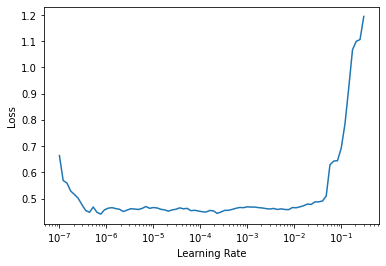

In [61]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.521263,0.573947,0.715272,0.689238,01:00
1,0.504734,0.579089,0.703673,0.694813,01:00
2,0.500345,0.562836,0.721348,0.704934,01:00
3,0.447303,0.566405,0.725214,0.720001,01:00
4,0.448699,0.568148,0.722452,0.717605,01:00


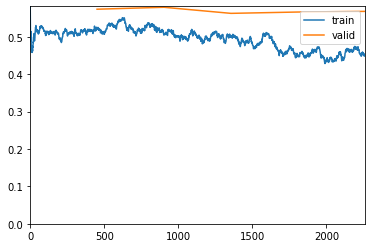

In [54]:
learner.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.459954,0.568462,0.723005,0.717657,01:01
1,0.449299,0.568530,0.722729,0.717750,01:02
2,0.451672,0.568598,0.723005,0.717764,01:03
3,0.450083,0.568617,0.723005,0.717729,01:00
4,0.444215,0.568620,0.723005,0.717692,01:02


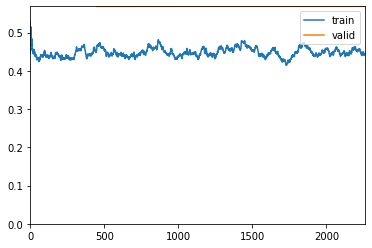

In [62]:
# Option khac
learner.fit_one_cycle(5,lr_max=3e-7,moms=(0.99,0.95, 0.99))

In [95]:
learner.show_results(dls.one_batch())

TypeError: list indices must be integers or slices, not tuple

,Unnamed: 0,id,question,title,text,label
0,0,u7-1570446247_1,Quang_Hải giành được chức vô_địch U21 quốc_gia năm bao_nhiêu tuổi,Nguyễn Quang Hải (sinh 1997),"Năm 2013 , Nguyễn_Quang_Hải giành chức vô_địch U21 quốc_gia 2013 cùng với đội trẻ Hà_Nội T&T và tạo nên cú sốc khi trở_thành cầu_thủ 16 tuổi đầu_tiên giành được danh_hiệu vô_địch U21 quốc_gia .",True


In [107]:
learner.predict(train_df.loc[0])

('False', tensor(0), tensor([0.5021, 0.4979]))

In [55]:
learner.export('drqa01.pkl')

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
set state called


In [56]:
learner.fit_one_cycle??

In [ ]:
learner = load_learner('drqa01.pkl')